In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pydicom
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour


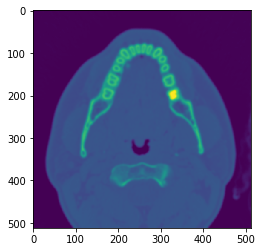

In [2]:
input_image = pydicom.read_file('/home/tiago/workspace/jaw/image.dcm')
pixel_array = input_image.pixel_array

plt.imshow(gaussian(pixel_array,1))
plt.show()

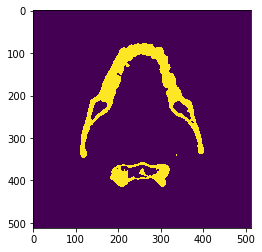

In [3]:
#the first step is to threshold the image around the expected bone value
img = pixel_array.copy() 
retval, threshold = cv2.threshold(img,1400,255,cv2.THRESH_BINARY)
plt.imshow(threshold)
plt.show()

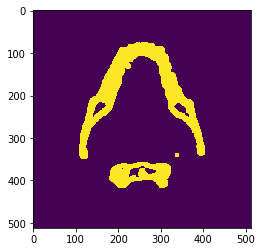

In [4]:
dilation_kernel = np.ones((6,6), np.uint16)
dilated_image = cv2.dilate(threshold, dilation_kernel)
plt.imshow(dilated_image)
plt.show()

In [5]:
def skeletonize_II(img):
    ka = np.array([-1,-1,-1,0,1,0,1,1,1]).reshape(3,3)
    kb = np.rot90(ka)
    kc = np.rot90(kb)
    kd = np.rot90(kc)
    la = np.array([0,-1,-1,1,1,-1,0,1,0]).reshape(3,3)
    lb = np.rot90(la)
    lc = np.rot90(lb)
    ld = np.rot90(lc)
    kernels = [ka,kb,kc,kd,la,lb,lc,ld]
    #these kernels are all the optionsfor simple point
    cpy = img.copy().astype(np.uint8)
    #for a in kernels:
    while True:
        start_of_loop = cpy.copy()
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[0])
        cpy = cpy - res
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[1])
        cpy = cpy - res
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[2])
        cpy = cpy - res
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[3])
        cpy = cpy - res
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[4])
        cpy = cpy - res
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[5])
        cpy = cpy - res
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[6])
        cpy = cpy - res
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[7])
        cpy = cpy - res
        if np.array_equal(start_of_loop,cpy):
           return cpy
    return cpy

In [6]:
def prune_skeleton(skel,pronation):
    ka = np.array([-1,-1,-1,-1,1,-1,-1,0,0]).reshape(3,3)
    kb = np.rot90(ka)
    kc = np.rot90(kb)
    kd = np.rot90(kc)
    la = np.array([-1,-1,-1,-1,1,-1,0,0,-1]).reshape(3,3)
    lb = np.rot90(la)
    lc = np.rot90(lb)
    ld = np.rot90(lc)
    kernels = [ka,kb,kc,kd,la,lb,lc,ld]
  
    cpy = skel.copy().astype(np.uint8)
    #for a in kernels:
    for i in range(0,pronation):
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[0])
        cpy = cpy - res
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[1])
        cpy = cpy - res
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[2])
        cpy = cpy - res
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[3])
        cpy = cpy - res
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[4])
        cpy = cpy - res
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[5])
        cpy = cpy - res
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[6])
        cpy = cpy - res
        res = cv2.morphologyEx(cpy,cv2.MORPH_HITMISS,kernels[7])
        cpy = cpy - res
    return cpy

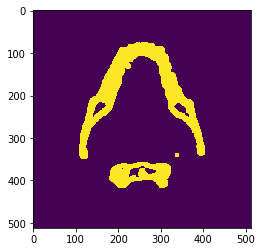

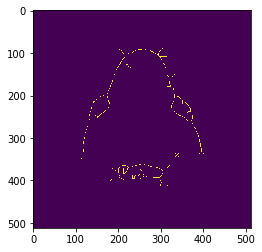

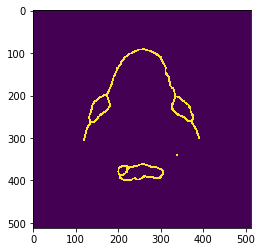

In [7]:
#here we sii a dilated image (so we increase local connectivity) then we skeletonize the  form  and  then remove the stubs
# from the skeleton. The final image is then regrown to active connectivity
uii = skeletonize_II(dilated_image)
ull = prune_skeleton(uii,20)
plt.imshow(dilated_image)
plt.show()
plt.imshow(uii)
plt.show()
plt.imshow(ull)
dilation_kernel = np.ones((4,4), np.uint16)
dilated_image = cv2.dilate(ull, dilation_kernel)
plt.imshow(dilated_image)
plt.show()

In [8]:
def find_non_zero_col(im, a):
    for x in range(0, im.shape[1]):
        if im[a][x] != 0:
            return x
    return im.shape[0]
    
def top_non_zero(im):    
    for a in range(0, im.shape[0]):
        if sum(im[a]) != 0:
            b = find_non_zero_col(im, a)           
            return a,b
    return (0,0)

def region_growing(image_in, fill_val, check_val):    
    map_of_maps = []    
    image = image_in.copy().astype(np.uint8)            
    while(np.sum(image) > 0 ):
        initial_row, initial_column = top_non_zero(image)        
        initial_value = image[initial_row, initial_column]        
        points_col =[initial_column]
        points_row =[initial_row]
        
        control_map = np.zeros(image.shape).astype(np.uint8)
        while (len(points_col) > 0) and (len(points_row) >0):
            r = points_row.pop()
            c = points_col.pop()
            control_map[r][c] = fill_val
            ru = r+1
            rd = r-1
            cr = c+1
            cl = c-1
            #only take into account neighbors that do not spill out of
            #the image... then fill it in the map and append it as a seed
            #for the next cycle        
            if rd >0 :
                if (control_map[rd][c] == 0) and(image[rd][c]==check_val):
                    points_row.append(rd)
                    points_col.append(c)
                    control_map[rd][c]=fill_val
            if cr < image.shape[1]:
                if (control_map[r][cr] == 0) and(image[r][cr]==check_val):
                    points_row.append(r)
                    points_col.append(cr)
                    control_map[r][cr]=fill_val
            if ru < image.shape[0]:
                if (control_map[ru][c] == 0) and(image[ru][c]==check_val):
                    points_row.append(ru)
                    points_col.append(c)
                    control_map[ru][c]=fill_val
            if cl > 0:
                if (control_map[r][cl] == 0) and(image[r][cl]==check_val):
                    points_row.append(r)
                    points_col.append(cl)
                    control_map[r][cl]=fill_val
        map_of_maps.append(control_map)
        image = cv2.bitwise_xor(image,control_map)
        map_of_maps = sorted(map_of_maps, key=lambda x: np.sum(x), reverse=True)
    return map_of_maps

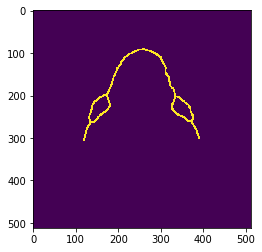

In [9]:
#by using a variation of regiongrowth we detect the largest image
clean_image = region_growing(dilated_image,255,255)[0]
plt.imshow(clean_image.astype(np.uint8))
plt.show()

In [10]:
def find_centroid_and_radius_of_skeleton(skeleton):
    # now for the active contour we will create an "elastic band" around the expected  form
    #lets find the centroid of the skeleton
    import math
    xa=0
    ya=0
    counter =0
    for px in range(0,clean_image.shape[1]):
        for py in range(0,clean_image.shape[0]):
            if skeleton[py][px] >0:
                counter +=1
                xa += px
                ya += py
    xa = xa / counter
    ya = ya / counter

    max_dist =0
    for px in range(0,clean_image.shape[1]):
        for py in range(0, clean_image.shape[0]):
            if skeleton[py][px] > 0:
               d = (px-xa)**2 + (py-ya)**2
               if d > max_dist:
                  max_dist = d
    max_dist = math.sqrt(max_dist)
    return xa,ya,max_dist

In [11]:
elastic_band_parameters = np.linspace(0.5*np.pi, -1.49*np.pi, 200)
xa,ya,rad = find_centroid_and_radius_of_skeleton(clean_image)
x = xa + 1.05*rad*np.cos(elastic_band_parameters)
y = ya + 1.05*rad*np.sin(elastic_band_parameters)
initial_values = np.array([x,y]).T

snake = active_contour(gaussian(clean_image,1), initial_values, alpha=0.07, w_line=8, beta =5, gamma=0.05)

[0, 512, 512, 0]

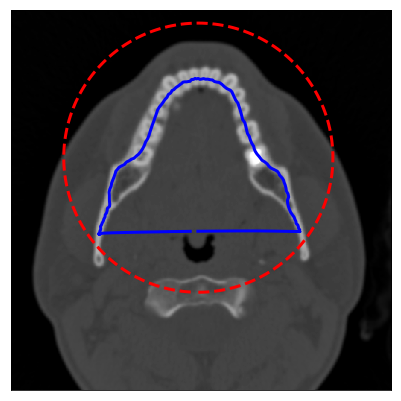

In [12]:
#plot the active contour (The red line is from where it starts and the blue line is where the system rests)
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(pixel_array, cmap=plt.cm.gray)
ax.plot(initial_values[:, 0], initial_values[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, pixel_array.shape[1], pixel_array.shape[0], 0])

In [13]:
#here we trimm the  active contour ..r emoving everything below the height of width apex points
min_y = np.min(snake[:,1])
max_y = np.max(snake[:,1])
range_y = max_y - min_y
tt = min_y + range_y*0.94
trimmed_snake = np.array([[s[0],s[1]] for s in snake if (s[1])  < tt])


[0, 512, 512, 0]

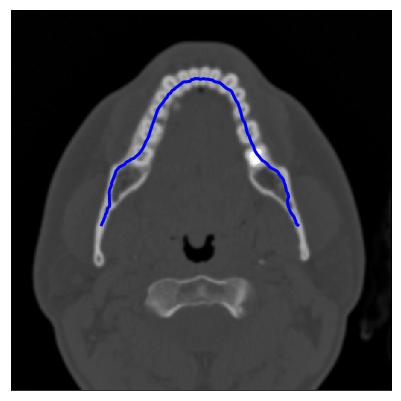

In [14]:
#here we render the scissored detected shape
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(pixel_array, cmap=plt.cm.gray)
ax.plot(trimmed_snake[:, 0], trimmed_snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, pixel_array.shape[1], pixel_array.shape[0], 0])

[0, 512, 512, 0]

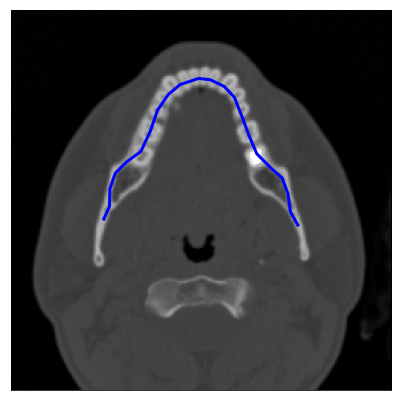

In [15]:
#here we simplify the line into  less points (important so the MPR does not get overloaded)
reduced_snake = np.array([trimmed_snake[x] for x in range(0,len(trimmed_snake)) if (x//6)*6== x ])
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(pixel_array, cmap=plt.cm.gray)
ax.plot(reduced_snake[:, 0], reduced_snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, pixel_array.shape[1], pixel_array.shape[0], 0])

In [16]:
len(reduced_snake)

23